# NMT using attention
## NOTICE : Attention layer is not yet implemented in keras library , which makes implementation of attention mechanism a lot difficult than other neural network models
## We can't use keras's model class and do model.fit , instead we'll have to write optimizer, loss function, model layers and training code from scratch and combine them to create a workflow. This is equivalent to writing model.fit in normal neural network models.

In [0]:

import tensorflow as tf
tf.enable_eager_execution()
from __future__ import absolute_import, division, print_function, unicode_literals


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [0]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [0]:
print(path_to_file)

/root/.keras/datasets/spa-eng/spa.txt


In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [0]:
def preprocess_sentence(w):
    
#     print("1 -> ",w)
    w = unicode_to_ascii(w.lower().strip())
    
#     print("2-> ",w)

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    
#     print("3 -> ",w)
    w = re.sub(r'[" "]+', " ", w)
    
#     print("4 -> ",w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
#     print("5 -> ",w)
    # rstrip() Remove spaces to the right of the string:
    # strip() removes all leading and tailing whitespaces"
    w = w.rstrip().strip()
    
#     print("6 -> ",w)
    # adding a start and an end token to the sentence
    # so that the m"odel know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
spanish = (preprocess_sentence(sp_sentence))
print(spanish.encode('utf-8'))
print(spanish)

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'
<start> ¿ puedo tomar prestado este libro ? <end>


In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    
    # io.open() Open file and return a corresponding stream.
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    
    # w = [eng_sent,spanish_sent]
    # l = [['eng \t spanish sent'] , ['eng spanish sent']]
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    return zip(*word_pairs)

In [0]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
    # default filter value is '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    # an instance of tokenizer
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    
    #takes all sentences in lang and makes dictionary for it
    lang_tokenizer.fit_on_texts(lang)
    
    #encodes the text -> (text ->vector)
    tensor = lang_tokenizer.texts_to_sequences(lang)

    #puts appropriate number of zeros after the sent
    # if maxlen of sentences if 100 and any given sentence is of len 20, then
    # it'll pad 80 zeros at the end
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    # tensor is a vector of n*maxlen
    # and lang_tokenizer is a dictionary mapping word with key 
    return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    #Return word pairs in the format: [ENGLISH, SPANISH]
    targ_lang, inp_lang = create_dataset(path, num_examples)

    #encoded sentence and dictionary for the same, dictionary will be used in embedding layer
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

## Limiting data

In [0]:
# Try experimenting with the size of that dataset
num_examples = 20000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [47]:
print(targ_lang.word_index['<start>'])
print(targ_lang.index_word)
dict_ = dict(targ_lang.index_word)
print(len(dict_))

1
{1: '<start>', 2: '<end>', 3: '.', 4: 'i', 5: 'you', 6: '?', 7: 'tom', 8: 'is', 9: 'it', 10: 's', 11: 'a', 12: 'he', 13: 't', 14: 'the', 15: 'we', 16: 'm', 17: 'me', 18: 're', 19: 'that', 20: 'this', 21: 'to', 22: 'do', 23: 'are', 24: 'can', 25: 'my', 26: 'they', 27: 'was', 28: '!', 29: 'she', 30: 'don', 31: 'have', 32: 'your', 33: 'go', 34: 'what', 35: 'in', 36: 'not', 37: 'll', 38: 'like', 39: 'here', 40: 'on', 41: 'him', 42: 'let', 43: 'be', 44: 'did', 45: 'know', 46: 'come', 47: 'up', 48: 'am', 49: 'want', 50: 'how', 51: ',', 52: 'mary', 53: 'get', 54: 'who', 55: 'very', 56: 'now', 57: 'need', 58: 'has', 59: 'please', 60: 'no', 61: 'there', 62: 'help', 63: 'her', 64: 'love', 65: 'at', 66: 'see', 67: 'just', 68: 'out', 69: 'his', 70: 've', 71: 'got', 72: 'for', 73: 'where', 74: 'look', 75: 'stop', 76: 'one', 77: 'us', 78: 'good', 79: 'car', 80: 'too', 81: 'so', 82: 'all', 83: 'why', 84: 'will', 85: 'an', 86: 'home', 87: 'of', 88: 'with', 89: 'give', 90: 'back', 91: 'were', 92: 'ke

In [0]:
print(max_length_inp,max_length_targ)

16 10


In [0]:
print("input tensor shape : ",input_tensor.shape)
print("target tensor shape : ",target_tensor.shape)
sent = en[1011]
print(sent,input_tensor[1011])

input tensor shape :  (20000, 16)
target tensor shape :  (20000, 10)
<start> he s broke . <end> [   1   13  229 1276    3    2    0    0    0    0    0    0    0    0
    0    0]


In [0]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

16000 16000 4000 4000


In [0]:
#This is what our model is going to learn
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
1133 ----> muestrame
93 ----> esa
291 ----> lista
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
269 ----> show
17 ----> me
19 ----> that
1070 ----> list
3 ----> .
2 ----> <end>


In [0]:
BUFFER_SIZE = len(input_tensor_train) #training set size
BATCH_SIZE = 32
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

#Creates a Dataset whose elements are slices of the given tensors.
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)

#Combines consecutive elements of this dataset into batches.
#eg dataset = tf.data.Dataset.range(8) 
# dataset = dataset.batch(3) 
# list(dataset.as_numpy_iterator()) 
# [ array([0,1,2]), array([3,4,5]) , array([5,6,7])]

dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
# so dataset loads 32 examples at a time for both input and output
# its a pointer to point to next batch when needed.
print(dataset)


<DatasetV1Adapter shapes: ((32, 16), (32, 10)), types: (tf.int32, tf.int32)>


In [0]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([Dimension(32), Dimension(16)]),
 TensorShape([Dimension(32), Dimension(10)]))

In [0]:
print(example_input_batch)

tf.Tensor(
[[   1  688   10  142    3    2    0    0    0    0    0    0    0    0
     0    0]
 [   1   40 5195    3    2    0    0    0    0    0    0    0    0    0
     0    0]
 [   1   13    7 1342    3    2    0    0    0    0    0    0    0    0
     0    0]
 [   1 4254    9 1167    3    2    0    0    0    0    0    0    0    0
     0    0]
 [   1    5   47   75   12   89    4    2    0    0    0    0    0    0
     0    0]
 [   1 2457   49 2458    3    2    0    0    0    0    0    0    0    0
     0    0]
 [   1  297 1611    3    2    0    0    0    0    0    0    0    0    0
     0    0]
 [   1   15 2811    3    2    0    0    0    0    0    0    0    0    0
     0    0]
 [   1    5   14  286    4    2    0    0    0    0    0    0    0    0
     0    0]
 [   1   15 1836    7  519    3    2    0    0    0    0    0    0    0
     0    0]
 [   1  244  322   10 2158    3    2    0    0    0    0    0    0    0
     0    0]
 [   1   57   17  114 6070    3    2    0    0    0   

## Making the model

![first_image](images/1.jpg)
![second_image](images/2.jpg)

FC = Fully connected (dense) layer
EO = Encoder output
H = hidden state
X = input to the decoder

## pseudo code
> score = FC(tanh(FC(EO) + FC(H)))  
> attention weights = softmax(score, axis = 1)  
> context vector = sum(attention weights * EO, axis = 1)  
> embedding output = The input to the decoder X is passed through an embedding layer.  
> merged vector = concat(embedding output, context vector)  

**return_sequences** -> give hidden state for each time step  
**return_state** -> gives (in case of lstm) [hidden state, hidden state, cell state for last time step].  
**both of them** -> (in case of lstm)[hidden state for all time step, hidden state for last time step, cell state for last time step]  
(in case of gru)[hidden state for all time steps, hidden state for final timestep]

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        #takes input and returns h and y
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
print(vocab_inp_size)
print(embedding_dim,units,BATCH_SIZE)

7177
256 1024 32


### sample output is hidden state of encoder for all timesteps that is {h1,h2,h3...h16}
### sample_hidden is output or hidden state for last time step.

In [0]:
# encoder is a class instance having 
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# not sure how this line is working..
sample_hidden = encoder.initialize_hidden_state()

sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))


Encoder output shape: (batch size, sequence length, units) (32, 16, 1024)
Encoder Hidden state shape: (batch size, units) (32, 1024)


In [0]:
print("shape of sample_hidden",sample_hidden.get_shape())

shape of sample_hidden (32, 1024)


## ATTENTION
### the attention weights for each example is different and to calculate that we use a feed forward neural network to get attention weights for each word in the sentence.
### here attention weights will be of the shape  (n,1,10)  
n is number of training examples  
10 is length of each sentence after being encoded

### hidden size = units = 1024
### value is actually {h1,h2,h3...h16}  : shape == (batch_size, max_len, hidden size)

### query is last hidden state of decoder that is h(t-1) 
### hi is hidden state , a vector of 1024 elements.


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        

        # query_with_time_axis shape == (batch_size, 1, hidden size) 
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [0]:
# this is just testing if attention is working or not
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (32, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (32, 16, 1)


In [0]:
print(sample_hidden)

tf.Tensor(
[[-0.014413   -0.00868872  0.00984907 ...  0.01606963  0.00927834
   0.02894218]
 [-0.01446477 -0.00865362  0.00996099 ...  0.01611441  0.00924119
   0.02900679]
 [-0.01442111 -0.00872763  0.00987569 ...  0.01607806  0.0092692
   0.02892711]
 ...
 [-0.01448955 -0.00864538  0.00989982 ...  0.016149    0.00918997
   0.02899837]
 [-0.01425114 -0.00896944  0.00969348 ...  0.01577897  0.00918904
   0.02860881]
 [-0.01451165 -0.00861996  0.01003067 ...  0.01614274  0.0092021
   0.02900198]], shape=(32, 1024), dtype=float32)


## decoder class
all the class variables are as defined above

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        # enc_output is the list of all the hidden states
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU

        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

### state is hidden state of gru for that time step
### output and state are the same thing here , as this is only for one time step
### output is :  Tensor("decoder_2/gru_5/transpose_1:0", shape=(32, 1, 1024), dtype=float32)
### state is :  Tensor("decoder_2/gru_5/while/Exit_3:0", shape=(32, 1024), dtype=float32)
notice the difference in shapes

### testing if decoder class is working


In [0]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 3728)


### as we cannot use the model funtion from keras here as mentioned above we'll have to write and combine loss function , optimizer and model.fit manually.

![third_image](images/3.png)


In [0]:
optimizer = tf.keras.optimizers.Adam()

'''
In the snippet below, there is a single floating point value per example for
`y_true` and `# classes` floating pointing values per example for `y_pred`.
The shape of `y_true` is `[batch_size]` and the shape of `y_pred` is
`[batch_size, num_classes]`.
'''
#Computes the crossentropy loss between the labels and predictions.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# only considering cross entropy for incorrectly classified samples.
def loss_function(real, pred):
    # tf.math.logical - Returns the truth value of NOT x element-wise.
    # tf.math.equal - Returns the truth value of (x == y) element-wise.
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # loss as defined in the image above
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
for (batch, (inp, targ)) in enumerate( dataset.take(steps_per_epoch) ):
    print(targ)
    print(targ.shape)
    break

tf.Tensor(
[[   1  160 1459    3    2    0    0    0    0    0]
 [   1    5   18  801    3    2    0    0    0    0]
 [   1   20    8   69    3    2    0    0    0    0]
 [   1  954   14  964    3    2    0    0    0    0]
 [   1   22    5   31   11  111    6    2    0    0]
 [   1  779    3    2    0    0    0    0    0    0]
 [   1   26   91  206    3    2    0    0    0    0]
 [   1   29   71  754    3    2    0    0    0    0]
 [   1   34   10  120   40    6    2    0    0    0]
 [   1 1165    8  503    3    2    0    0    0    0]
 [   1    4  168   33   21  226    3    2    0    0]
 [   1   26   74  742    3    2    0    0    0    0]
 [   1    7   10 2095    3    2    0    0    0    0]
 [   1   85 2217   27  113    3    2    0    0    0]
 [   1    4   71   25  268  468    3    2    0    0]
 [   1   50  490   44    5   33    6    2    0    0]
 [   1   19    8   82    3    2    0    0    0    0]
 [   1   30   13 1212    3    2    0    0    0    0]
 [   1    7  101   13  217    5    

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
flag = 1

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
    '''
    inp is encoded input sentence 
    targ is encoded output sentence(batchsize,len_of_target_word)
    enc_hidden is zero vector of shape (batchsize,units)
    '''
    loss = 0

    with tf.GradientTape() as tape:
        #recoder or tracks variable values
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        
        # targ_lang.word_index['<start>'] - returns dictionary value of start token
        # dec_input is batch_size
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            #enc_output is list of all hidden states of encoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            # this is simply the loss between t th predicted word and its prediction
            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            # expand_dims is to change dimention such that it can act as timesteps
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    # explanationn of this part https://www.tensorflow.org/guide/effective_tf2
    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

## operation code 

In [0]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    # returns a zero vector of shape(batch_size,units)
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    # dataset is tf.data.Dataset() object.
    for (batch, (inp, targ)) in enumerate( dataset.take(steps_per_epoch) ):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1 Loss 1.9837
Time taken for 1 epoch 64.3696551322937 sec

Epoch 2 Loss 1.3402
Time taken for 1 epoch 43.472676515579224 sec

Epoch 3 Loss 0.9677
Time taken for 1 epoch 43.29481768608093 sec

Epoch 4 Loss 0.6615
Time taken for 1 epoch 43.56736493110657 sec

Epoch 5 Loss 0.4284
Time taken for 1 epoch 43.27933359146118 sec

Epoch 6 Loss 0.2765
Time taken for 1 epoch 43.56578516960144 sec

Epoch 7 Loss 0.1818
Time taken for 1 epoch 43.716572761535645 sec

Epoch 8 Loss 0.1280
Time taken for 1 epoch 43.63137888908386 sec

Epoch 9 Loss 0.1044
Time taken for 1 epoch 43.20781922340393 sec

Epoch 10 Loss 0.0861
Time taken for 1 epoch 43.60098576545715 sec



## Evaluator
The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.

In [0]:
def evaluate(sentence):
  # this is for the heat map
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  #convert input to its embeddings
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_inp,
                                                          padding='post')
  inputs = tf.convert_to_tensor(inputs)

  # we'll keep appending the predicted word in this
  result = ''

  # got all the hidden states and last encoder hidden state
  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  # for first timestep decoder hidden state = encoder hidden state
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  # keep feeding words in decoder for no of words in target sentence
  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                          dec_hidden,
                                                          enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    # max value from probability of all words in target sentence
    predicted_id = tf.argmax(predictions[0]).numpy()
    print(predictions.shape,predictions)
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

# Restore the latest checkpoint and test

In [42]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## checking

(1, 3728) tf.Tensor([[-5.240873  -4.607679   0.5433209 ... -3.7884514 -4.172498  -5.356888 ]], shape=(1, 3728), dtype=float32)
(1, 3728) tf.Tensor(
[[-2.972187   -2.4347107  -0.71215403 ... -2.887904   -0.64589614
  -3.2920468 ]], shape=(1, 3728), dtype=float32)
(1, 3728) tf.Tensor([[-9.27494   -8.359457  -5.9413548 ... -8.206115  -7.933142  -9.498923 ]], shape=(1, 3728), dtype=float32)
(1, 3728) tf.Tensor([[-5.6119537 -4.6771717 -5.499144  ... -3.3513527 -5.252321  -4.874863 ]], shape=(1, 3728), dtype=float32)
(1, 3728) tf.Tensor(
[[-10.703559   -9.318482    1.0674783 ...  -9.366171   -9.715652
   -9.991129 ]], shape=(1, 3728), dtype=float32)
(1, 3728) tf.Tensor([[ 1.5591072  1.3505776 23.610983  ... -0.1415377 -2.9373422  1.4197962]], shape=(1, 3728), dtype=float32)
Input: <start> hace mucho frio aqui . <end>
Predicted translation: he s very hot . <end> 


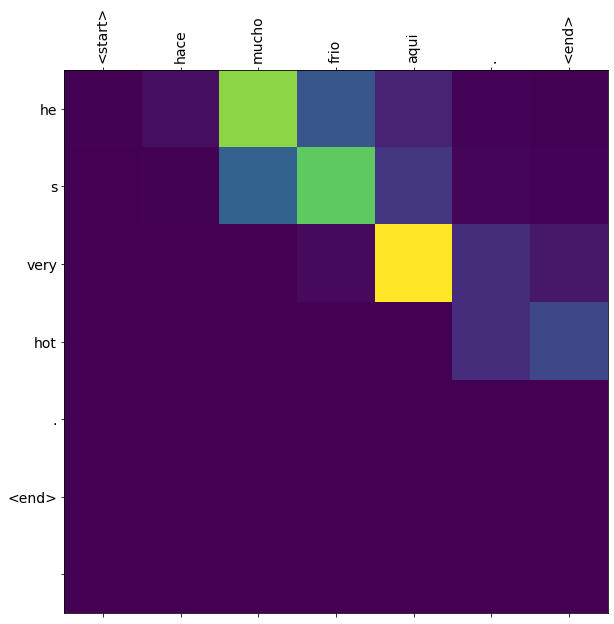

In [43]:
translate(u'hace mucho frio aqui.')
